In [1]:
# -*- coding: utf-8 -*-
import time
import datasets
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

c:\Users\Davidgu\anaconda3\envs\tensorflow-cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 讀取訓練資料

In [2]:
# https://huggingface.co/datasets/thuml/UTSD
# https://github.com/thuml/Large-Time-Series-Model/tree/main

ds = datasets.load_dataset("thuml/UTSD", "UTSD-1G")
# ds = datasets.load_dataset("thuml/UTSD", "UTSD-2G")
# ds = datasets.load_dataset("thuml/UTSD", "UTSD-4G")
# ds = datasets.load_dataset("thuml/UTSD", "UTSD-12G")

all = ds["train"]
print(f'total {len(all)} single-variate series')
print(all[0].keys())

for k, v in all[0].items():
    print(f'{k}: {type(v)}')
    if k == 'target':
        print(f'    {v[:10]}')
    else:
        print(f'    {v}')

c:\Users\Davidgu\anaconda3\envs\tensorflow-cpu\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Davidgu\.cache\huggingface\hub\datasets--thuml--UTSD. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 68679 examples [00:00, 107553.08 examples/s]

total 68679 single-variate series
dict_keys(['item_id', 'start', 'end', 'freq', 'target'])
item_id: <class 'str'>
    Health_SelfRegulationSCP1_458_0
start: <class 'str'>
    
end: <class 'str'>
    
freq: <class 'str'>
    
target: <class 'list'>
    [-8.119999885559082, -11.5600004196167, -14.279999732971191, -18.190000534057617, -20.030000686645508, -20.84000015258789, -20.09000015258789, -19.5, -18.059999465942383, -17.25]


In [3]:
data = all[68547]['target']
data_len = len(data)
df_Energy_wind = pd.DataFrame({"points":list(range(data_len)),"Power(kW)":data})
df_Energy_wind.head()

,points,Power(kW)
0,0,18.6
1,1,18.6
2,2,18.6
3,3,18.6
4,4,18.6


## 定義所有超參數

In [4]:
# 定義上下文區間
window_size = 10
stride = 2
max_point = 28000

#訓練參數
lr = 1e-3
epochs = 300
batch_size = 64

#存檔參數
model_name = f"ar_dnn-w{window_size}-l16-l32-l16_windfarm_0620"

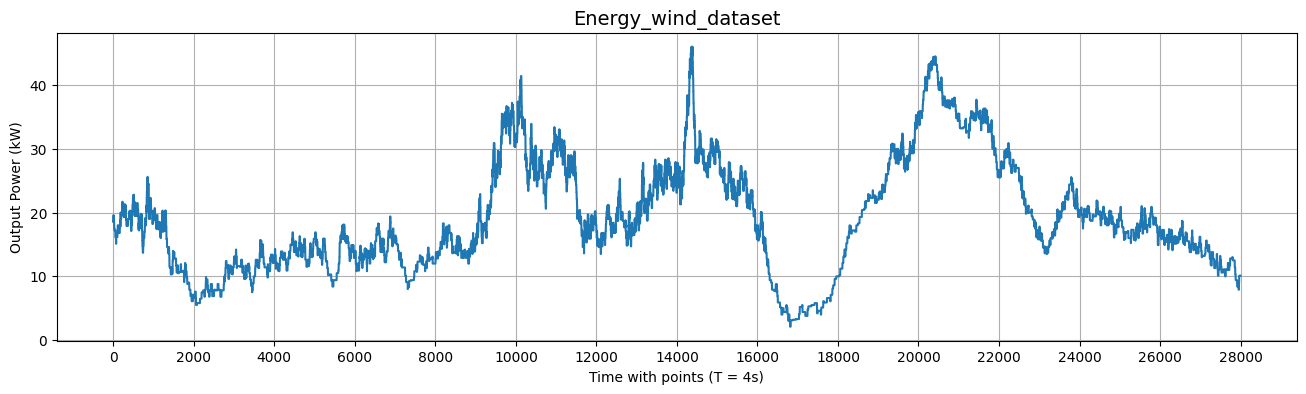

In [5]:
#plot data
plt.figure(figsize=(16, 4))  # 寬 16，高 4，可依需求再放大
plt.plot(data[:max_point])
plt.xlabel('Time with points (T = 4s)')
plt.ylabel('Output Power (kW)')
plt.title('Energy_wind_dataset', fontsize=14)
# 設定 x 軸每 100 點畫一條 grid 線
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(2000))  # 每 1000 點一格
plt.grid(True)
plt.show()

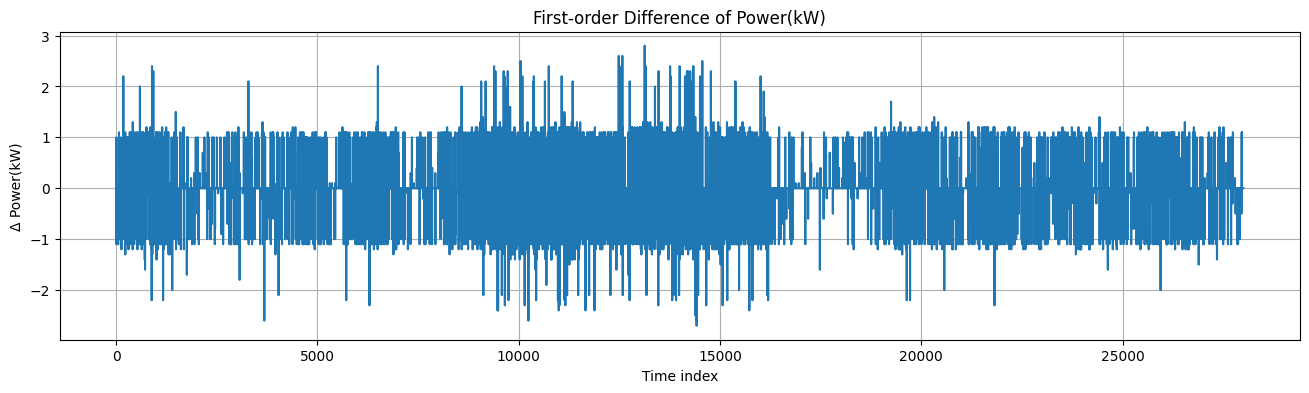

In [6]:
df_Energy_wind['diff1'] = df_Energy_wind['Power(kW)'].diff(1)
# 若只想要純差分序列 (去掉 NaN)
diff_series = df_Energy_wind['diff1'].dropna()

plt.figure(figsize=(16, 4))  # 寬 16，高 4，可依需求再放大
plt.plot(diff_series[:max_point])
plt.title('First-order Difference of Power(kW)')
plt.xlabel('Time index')
plt.ylabel('Δ Power(kW)')
plt.grid(True)
plt.show()

In [7]:
# 5 點移動平均（預設右端對齊）
df_Energy_wind['moving_ave_5'] = (
    df_Energy_wind['Power(kW)']
    .rolling(window=5,   # 視窗長度 5 筆
             min_periods=1)  # 前幾筆不足 5 也先算平均，避免 NaN
    .mean()
)


# 10 點移動平均（預設右端對齊）
df_Energy_wind['moving_ave_10'] = (
    df_Energy_wind['Power(kW)']
    .rolling(window=10,
             min_periods=1)
    .mean()
)



# 20 點移動平均（預設右端對齊）
df_Energy_wind['moving_ave_20'] = (
    df_Energy_wind['Power(kW)']
    .rolling(window=20,
             min_periods=1)
    .mean()
)

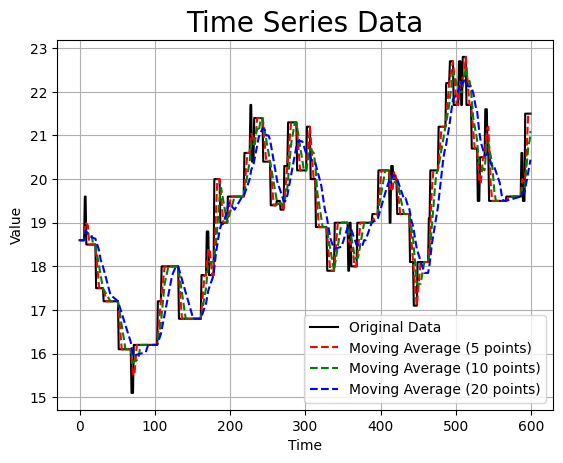

In [8]:
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(df_Energy_wind['Power(kW)'][:600], label='Original Data',c='black')
plt.plot(df_Energy_wind['moving_ave_5'][:600], label='Moving Average (5 points)', c='red', linestyle='--')
plt.plot(df_Energy_wind['moving_ave_10'][:600], label='Moving Average (10 points)', c='green', linestyle='--')
plt.plot(df_Energy_wind['moving_ave_20'][:600], label='Moving Average (20 points)', c='blue', linestyle='--')
plt.legend(fontsize=10)
plt.show()

## Sequence-to-one Learning

In [9]:
#產生特徵(AR window)
def create_dataset(data, window_size=5, stride=1):
    X, Y = [], []
    for i in range(0, len(data) - window_size, stride):  # 每次移動 stride 步
        X.append(data[i:i + window_size])
        Y.append(data[i + window_size])
    return np.array(X), np.array(Y)

# 增加噪聲
def add_noise(data, noise_level=0.1):
    data = np.array(data)
    noise = np.random.normal(0, noise_level, len(data))
    return data + noise


# 定義資料範圍
data_samples = add_noise(df_Energy_wind['moving_ave_20'].to_list()[:max_point])
# 標準化
mean, std = data_samples.mean(), data_samples.std()
data_samples = (data_samples - mean) / std

# create訓練資料
X,y = create_dataset(data = data_samples,
                     window_size = window_size,
                     stride = stride)
print(f"X_all.shape, y_all.shape = {X.shape}, {y.shape}")

# 切分訓練 / 驗證
split = int(len(X)*0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print(f"X_train.shape, y_train.shape = {X_train.shape}, {y_train.shape}")
print(f"X_val.shape, y_val.shape = {X_val.shape}, {y_val.shape}")

X_all.shape, y_all.shape = (13995, 10), (13995,)
X_train.shape, y_train.shape = (11196, 10), (11196,)
X_val.shape, y_val.shape = (2799, 10), (2799,)


In [10]:
#模型建立
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(X.shape[1],)),   # window_size = X.shape[1]
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),   # window_size = X.shape[1]
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='mse',
    metrics=['mae'] # 多觀察一個 MAE
)


# callback：早停＋動態調 lr
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"./checkpoints/ar_dnn/{model_name}.keras", 
        monitor="val_loss",
        save_best_only=True, 
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        verbose=1
    )
]

#訓練
ts = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=2
)
te = time.time()
print("\n time cost for training: %.2f sec" % (te-ts))

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.00080, saving model to ./checkpoints/ar_dnn/ar_dnn-w10-l16-l32-l16_windfarm_0620.keras
175/175 - 1s - 7ms/step - loss: 0.0869 - mae: 0.1322 - val_loss: 8.0469e-04 - val_mae: 0.0220 - learning_rate: 1.0000e-03
Epoch 2/300

Epoch 2: val_loss improved from 0.00080 to 0.00072, saving model to ./checkpoints/ar_dnn/ar_dnn-w10-l16-l32-l16_windfarm_0620.keras
175/175 - 0s - 1ms/step - loss: 8.2859e-04 - mae: 0.0220 - val_loss: 7.1678e-04 - val_mae: 0.0210 - learning_rate: 1.0000e-03
Epoch 3/300

Epoch 3: val_loss improved from 0.00072 to 0.00060, saving model to ./checkpoints/ar_dnn/ar_dnn-w10-l16-l32-l16_windfarm_0620.keras
175/175 - 0s - 1ms/step - loss: 7.2626e-04 - mae: 0.0209 - val_loss: 6.0484e-04 - val_mae: 0.0194 - learning_rate: 1.0000e-03
Epoch 4/300

Epoch 4: val_loss improved from 0.00060 to 0.00042, saving model to ./checkpoints/ar_dnn/ar_dnn-w10-l16-l32-l16_windfarm_0620.keras
175/175 - 0s - 1ms/step - loss: 5.8617e-04 - mae: 

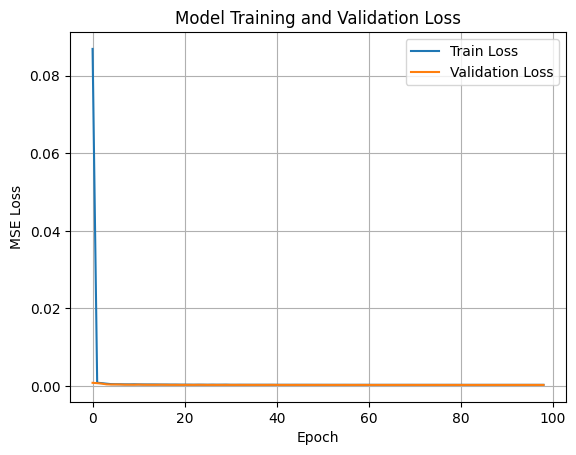

In [11]:
#繪製loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# 儲存std, mean to a csv 不要有標頭
std_mean_out = {
    'std': std,
    'mean': mean
}
pd.Series(std_mean_out).to_csv(f'./checkpoints/ar_dnn/{model_name}-std-mean.csv', header=False)


# 非量化轉換(保留原模型大小)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_no_quantized = converter.convert()

with open(f"./checkpoints/ar_dnn/{model_name}.tflite", "wb") as f:
    f.write(tflite_model_no_quantized)

INFO:tensorflow:Assets written to: C:\Users\Davidgu\AppData\Local\Temp\tmpud8zfkjy\assets


INFO:tensorflow:Assets written to: C:\Users\Davidgu\AppData\Local\Temp\tmpud8zfkjy\assets


Saved artifact at 'C:\Users\Davidgu\AppData\Local\Temp\tmpud8zfkjy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2614508564560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2614508558224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2614508567440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2614508563984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2614508558992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2614508565328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2614508559568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2614508556688: TensorSpec(shape=(), dtype=tf.resource, name=None)


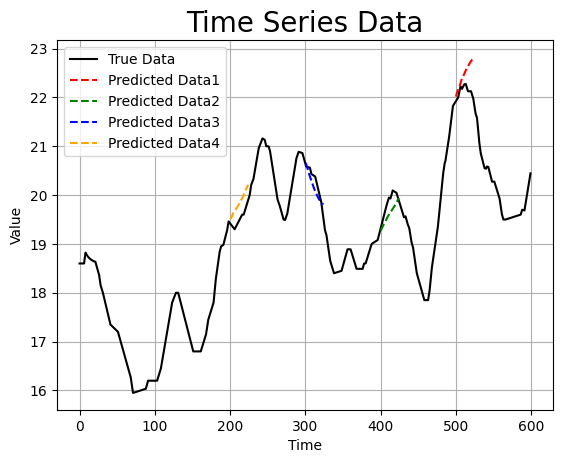

In [13]:
def autoregressive_forecast(model, init_window, n_steps, window_size, mean=0, std=1):
    window = (init_window - mean) / std
    preds = []
    for _ in range(n_steps):
        input_data = window[-window_size:].reshape(1, -1)
        next_val = model.predict(input_data, verbose=0)[0, 0]
        preds.append(next_val)
        window = np.append(window, next_val)
    return np.array(preds) * std + mean



# prediction
n_steps = 25
org_test_samples = np.array(df_Energy_wind['moving_ave_20'][:600])
test_samples_1 = org_test_samples[:500]
preds1 = autoregressive_forecast(model, test_samples_1, n_steps=n_steps, window_size=window_size, mean=mean, std=std)

test_samples_2 = org_test_samples[:400]
preds2 = autoregressive_forecast(model, test_samples_2, n_steps=n_steps, window_size=window_size, mean=mean, std=std)

test_samples_3 = org_test_samples[:300]
preds3 = autoregressive_forecast(model, test_samples_3, n_steps=n_steps, window_size=window_size, mean=mean, std=std)

test_samples_4 = org_test_samples[:200]
preds4 = autoregressive_forecast(model, test_samples_4, n_steps=n_steps, window_size=window_size, mean=mean, std=std)

# 繪製模擬資料+預測資料 PS:迴歸模型普遍現象: 誤差逐步累積
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(range(len(org_test_samples)),org_test_samples, label='True Data',c='black')
plt.plot(range(len(test_samples_1),len(test_samples_1)+n_steps), preds1, label='Predicted Data1',c='red', linestyle='--')
plt.plot(range(len(test_samples_2),len(test_samples_2)+n_steps), preds2, label='Predicted Data2',c='green', linestyle='--')
plt.plot(range(len(test_samples_3), len(test_samples_3)+n_steps), preds3, label='Predicted Data3', c='blue', linestyle='--')
plt.plot(range(len(test_samples_4), len(test_samples_4)+n_steps), preds4, label='Predicted Data4', c='orange', linestyle='--')
plt.legend(fontsize=10)
plt.show()

In [14]:
def autoregressive_forecast_on_train_valid(model, init_window, n_steps, window_size, mean=0, std=1):
    window = np.copy(init_window) # 已經標準化過這邊無須再進行一次
    preds = []
    for _ in range(n_steps):
        input_data = window[-window_size:].reshape(1, -1)
        next_val = model.predict(input_data, verbose=0)[0, 0]
        preds.append(next_val)
        window = np.append(window, next_val)
    return np.array(preds) * std + mean

# use stride and window size
original_data_stride = df_Energy_wind['moving_ave_20'].to_list()[window_size:max_point:stride]
original_train_data = original_data_stride[:split]
original_test_data = original_data_stride[split:]

# predict on training data
preds_train = []
for _train_data in X_train:
    _preds = autoregressive_forecast_on_train_valid(model, _train_data, n_steps=1, window_size=window_size, mean=mean, std=std)
    preds_train.append(_preds[0])

print("Train preds finished")
    
# predict on testing data
preds_test = []
for _test_data in X_val:
    _preds = autoregressive_forecast_on_train_valid(model, _test_data, n_steps=1, window_size=window_size, mean=mean, std=std)
    preds_test.append(_preds[0])

print("Test preds finished")

Train preds finished
Test preds finished


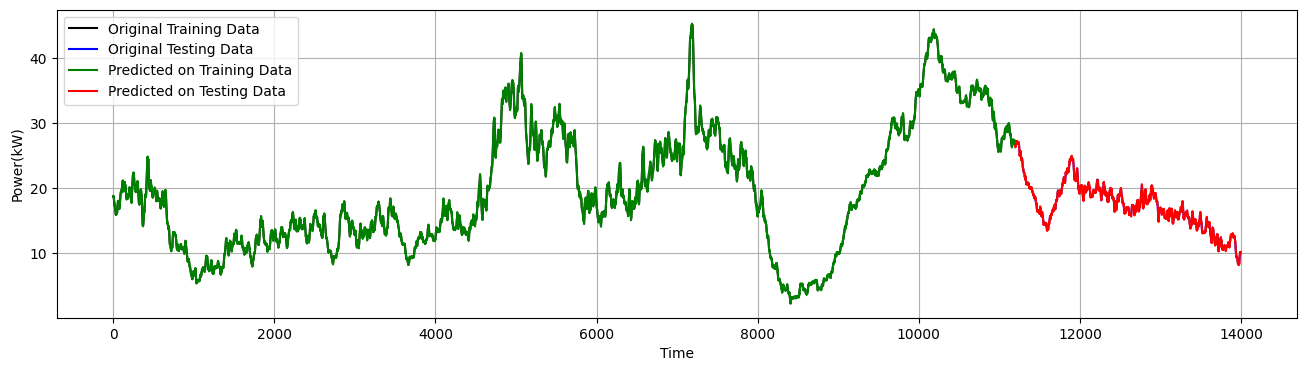

In [15]:
# 繪製模擬資料+預測資料
plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Power(kW)')
plt.plot(range(len(original_train_data)),original_train_data, label='Original Training Data',c='black')
plt.plot(range(len(original_train_data),len(original_train_data)+len(original_test_data)),original_test_data, label='Original Testing Data',c='blue')
plt.plot(range(len(X_train)), preds_train, label='Predicted on Training Data',c='green')
plt.plot(range(len(X_train),len(X_train)+len(X_val)), preds_test, label='Predicted on Testing Data',c='red')
plt.legend(fontsize=10,loc='upper left')
plt.show()

In [16]:
# 計算各項分數
def compute_mae(y_true, y_pred):
    _y_pred = np.asarray(y_pred, dtype=float)
    _y_true = np.asarray(y_true, dtype=float)
    mae = mean_absolute_error(_y_true, _y_pred)
    # mae = np.mean(np.abs(_y_true - _y_pred))
    return mae

def compute_rmse(y_true, y_pred):
    _y_pred = np.asarray(y_pred, dtype=float)
    _y_true = np.asarray(y_true, dtype=float)
    rmse = np.sqrt(mean_squared_error(_y_true, _y_pred))
    return rmse


def compute_r2(y_true, y_pred):
    _y_pred = np.asarray(y_pred, dtype=float)
    _y_true = np.asarray(y_true, dtype=float)
    r2 = r2_score(_y_true, _y_pred)
    return r2

In [17]:
# Training Data Score
mae_train = compute_mae(original_train_data, preds_train)
rmse_train = compute_rmse(original_train_data, preds_train)
r2_train = compute_r2(original_train_data, preds_train)
# Testing Data Score
mae_test = compute_mae(original_test_data, preds_test)
rmse_test = compute_rmse(original_test_data, preds_test)
r2_test = compute_r2(original_test_data, preds_test)

print(f"Training Data Score: MAE = {mae_train:.6f}, RMSE = {rmse_train:.6f}, R² = {r2_train:.6f}")
print(f"Testing Data Score: MAE = {mae_test:.6f}, RMSE = {rmse_test:.6f}, R² = {r2_test:.6f}")

Training Data Score: MAE = 0.083522, RMSE = 0.106075, R² = 0.999872
Testing Data Score: MAE = 0.077530, RMSE = 0.097909, R² = 0.999258


## Comparison between C++ and Python

In [ ]:
# 匯出預測數據
pd.Series(test_samples_3).to_csv("./checkpoints/ar_dnn/input-dnn.csv", header=False, index=False)
print(preds3)

[20.66454508 20.62878366 20.58370296 20.53699463 20.48060757 20.42521919
 20.37965683 20.33698211 20.29532797 20.24767374 20.20162557 20.15796794
 20.11620952 20.07995978 20.04531937 20.01095872 19.97738083 19.94559941
 19.9177857  19.8920996  19.86884356 19.84796223 19.83138686 19.81899095
 19.81090854]


In [20]:
# 讀取C++預測的結果
preds3_cpp = []
with open("./checkpoints/ar_dnn/output-dnn.csv", 'r') as f:
    for line in f:
        preds3_cpp.append(float(line.strip()))
print(preds3_cpp)

[20.6645, 20.6288, 20.5837, 20.537, 20.4806, 20.4252, 20.3797, 20.337, 20.2953, 20.2477, 20.2016, 20.158, 20.1162, 20.08, 20.0453, 20.011, 19.9774, 19.9456, 19.9178, 19.8921, 19.8688, 19.848, 19.8314, 19.819, 19.8109]


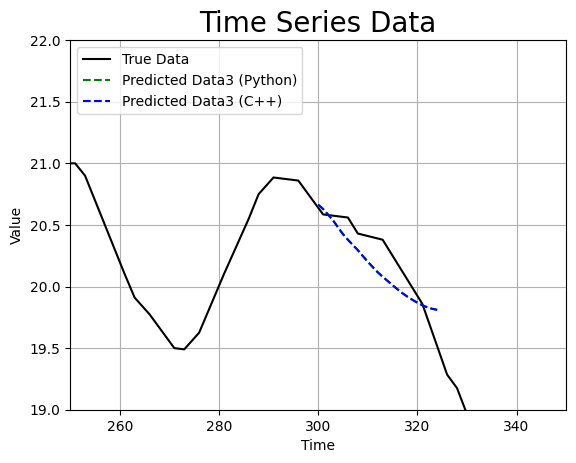

In [21]:
# 繪製C++預測的結果
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(range(len(org_test_samples)),org_test_samples, label='True Data',c='black')
plt.plot(range(len(test_samples_3),len(test_samples_3)+n_steps), preds3, label='Predicted Data3 (Python)',c='green', linestyle='--')
plt.plot(range(len(test_samples_3), len(test_samples_3)+n_steps), preds3_cpp, label='Predicted Data3 (C++)', c='blue', linestyle='--')
# 設定軸範圍
plt.xlim(250, 350)
plt.ylim(19, 22)

plt.legend(fontsize=10, loc='upper left')
plt.show()